## Grokking Hacking 1

In [2]:
import os
import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"
branch = "main"

# Install dependencies
try:
    import transformer_lens
except:
    %pip install transformer_lens==2.11.0

# Get root directory, handling 3 different cases: (1) Colab, (2) notebook not in ARENA repo, (3) notebook in ARENA repo
root = (
    "/content"
    if IN_COLAB
    else "/root"
    if repo not in os.getcwd()
    else str(next(p for p in Path.cwd().parents if p.name == repo))
)

if Path(root).exists() and not Path(f"{root}/{chapter}").exists():
    if not IN_COLAB:
        !sudo apt-get install unzip
        %pip install jupyter ipython --upgrade

    if not os.path.exists(f"{root}/{chapter}"):
        !wget -P {root} https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/{branch}.zip
        !unzip {root}/{branch}.zip '{repo}-{branch}/{chapter}/exercises/*' -d {root}
        !mv {root}/{repo}-{branch}/{chapter} {root}/{chapter}
        !rm {root}/{branch}.zip
        !rmdir {root}/{repo}-{branch}

if f"{root}/{chapter}/exercises" not in sys.path:
    sys.path.append(f"{root}/{chapter}/exercises")

os.chdir(f"{root}/{chapter}/exercises")

In [3]:
import os
import sys
from functools import partial
from pathlib import Path

import einops
import numpy as np
import torch as t
import torch.nn.functional as F
from huggingface_hub import hf_hub_download
from jaxtyping import Float
from torch import Tensor
from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
from transformer_lens.utils import to_numpy
import matplotlib.pyplot as plt

# Make sure exercises are in the path
chapter = "chapter1_transformer_interp"
section = "part52_grokking_and_modular_arithmetic"
root_dir = next(p for p in Path.cwd().parents if (p / chapter).exists())
exercises_dir = root_dir / chapter / "exercises"
section_dir = exercises_dir / section

grokking_root = section_dir / "Grokking"
saved_runs_root = grokking_root / "saved_runs"

import part52_grokking_and_modular_arithmetic.tests as tests
import part52_grokking_and_modular_arithmetic.utils as utils

device = t.device("cuda" if t.cuda.is_available() else "cpu")

t.set_grad_enabled(False)

MAIN = __name__ == "__main__"

In [4]:
p = 113

cfg = HookedTransformerConfig(
    n_layers=1,
    d_vocab=p + 1,
    d_model=128,
    d_mlp=4 * 128,
    n_heads=4,
    d_head=128 // 4,
    n_ctx=3,
    act_fn="relu",
    normalization_type=None,
    device=device,
)

model = HookedTransformer(cfg)

In [5]:
if not grokking_root.exists():
    os.system(
        f'git clone https://github.com/neelnanda-io/Grokking.git "{grokking_root.as_posix()}"'
    )
    assert grokking_root.exists()
    os.mkdir(grokking_root / "large_files")

In [7]:
REPO_ID = "callummcdougall/grokking_full_run_data"
FILENAME = "full_run_data.pth"

local_dir = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

full_run_data = t.load(local_dir, weights_only=True)
state_dict = full_run_data["state_dicts"][400]

model = utils.load_in_state_dict(model, state_dict)

In [8]:
# Helper variables
W_O = model.W_O[0]
W_K = model.W_K[0]
W_Q = model.W_Q[0]
W_V = model.W_V[0]
W_in = model.W_in[0]
W_out = model.W_out[0]
W_pos = model.W_pos
W_E = model.W_E[:-1]
final_pos_resid_initial = model.W_E[-1] + W_pos[2]
W_U = model.W_U[:, :-1]

print("W_O  ", tuple(W_O.shape))
print("W_K  ", tuple(W_K.shape))
print("W_Q  ", tuple(W_Q.shape))
print("W_V  ", tuple(W_V.shape))
print("W_in ", tuple(W_in.shape))
print("W_out", tuple(W_out.shape))
print("W_pos", tuple(W_pos.shape))
print("W_E  ", tuple(W_E.shape))
print("W_U  ", tuple(W_U.shape))

W_O   (4, 32, 128)
W_K   (4, 128, 32)
W_Q   (4, 128, 32)
W_V   (4, 128, 32)
W_in  (128, 512)
W_out (512, 128)
W_pos (3, 128)
W_E   (113, 128)
W_U   (128, 113)


In [9]:
# W_O

In [10]:
# Get all data and labels, and cache activations
all_data = t.tensor([(i, j, p) for i in range(p) for j in range(p)]).to(device)
labels = t.tensor([utils.target_fn(i, j) for i, j, _ in all_data]).to(device)
original_logits, cache = model.run_with_cache(all_data)

# Final position only, also remove the logits for `=`
original_logits = original_logits[:, -1, :-1]

# Get cross entropy loss
original_loss = utils.cross_entropy_high_precision(original_logits, labels)
print(f"Original loss: {original_loss.item():.3e}")

Original loss: 2.412e-07


Good point to start poking around

In [11]:
cache.keys()

dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post'])

In [12]:
for k in cache.keys():
    print(k, cache[k].shape)

hook_embed torch.Size([12769, 3, 128])
hook_pos_embed torch.Size([12769, 3, 128])
blocks.0.hook_resid_pre torch.Size([12769, 3, 128])
blocks.0.attn.hook_q torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_k torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_v torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_attn_scores torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_pattern torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_z torch.Size([12769, 3, 4, 32])
blocks.0.hook_attn_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_mid torch.Size([12769, 3, 128])
blocks.0.mlp.hook_pre torch.Size([12769, 3, 512])
blocks.0.mlp.hook_post torch.Size([12769, 3, 512])
blocks.0.hook_mlp_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_post torch.Size([12769, 3, 128])


In [13]:
input_1=t.tensor([[60, 60, 113]]).to(device)
out_1=model(input_1)
out_1[0, -1, :-1].argmax()

tensor(7, device='cuda:0')

### Ok, let's start with weights, then do activations.

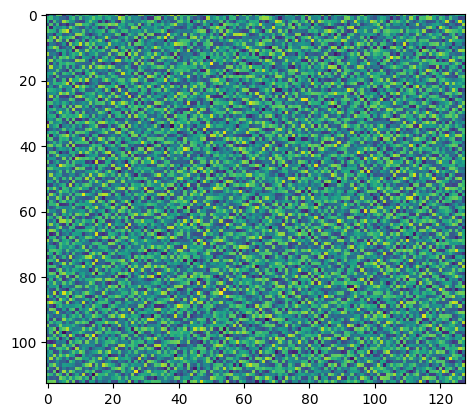

In [14]:
plt.imshow(W_E.detach().cpu().numpy())

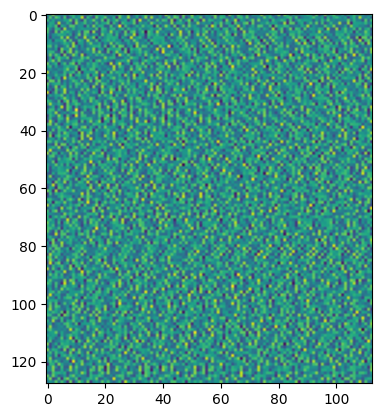

In [15]:
plt.imshow(W_U.detach().cpu().numpy())

In [16]:
W_E[0,:].shape

torch.Size([128])

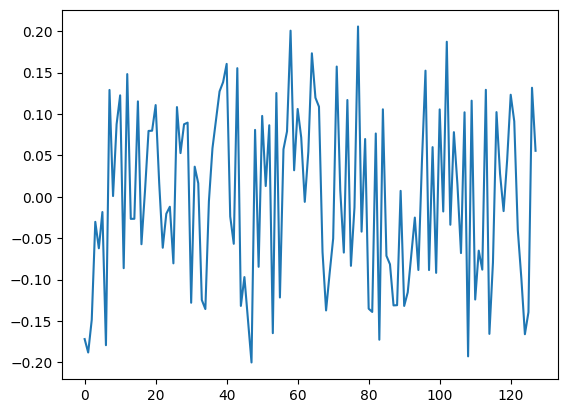

In [17]:
plt.plot(W_E[100,:].detach().cpu().numpy())

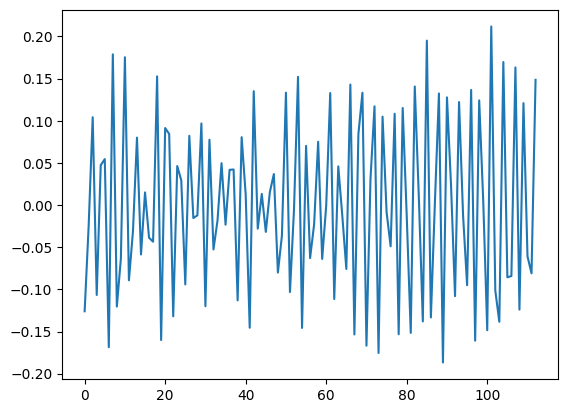

In [18]:
plt.plot(W_E[:,2].detach().cpu().numpy())

In [19]:
W_E[:,20].shape

torch.Size([113])

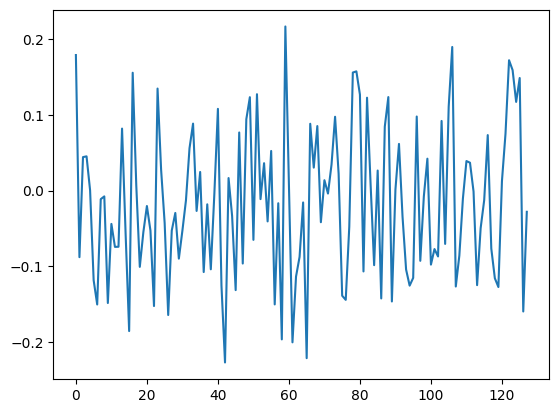

In [20]:
plt.plot(W_U[:,2].detach().cpu().numpy())

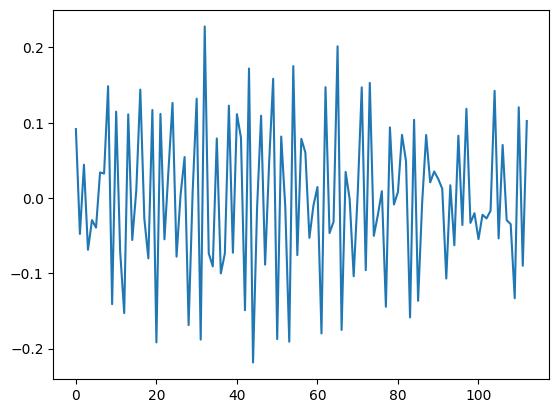

In [21]:
plt.plot(W_U[2,:].detach().cpu().numpy())

Ok sure so like maybe some structure, but nothing I would pick upon yet!

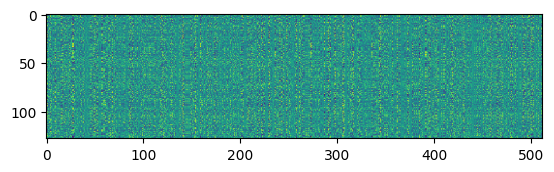

In [22]:
plt.imshow(W_in.detach().cpu().numpy())

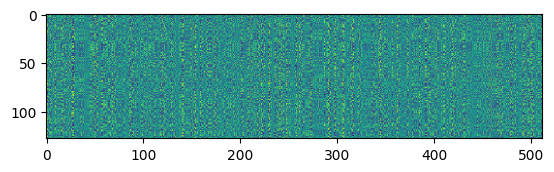

In [23]:
plt.imshow(W_out.detach().cpu().numpy().T)

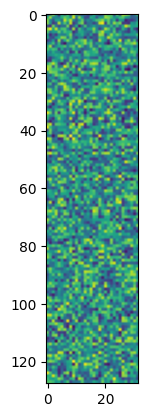

In [24]:
plt.imshow(W_O[0].detach().cpu().numpy().T)

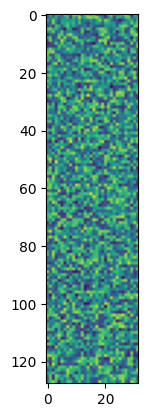

In [25]:
plt.imshow(W_O[1].detach().cpu().numpy().T)

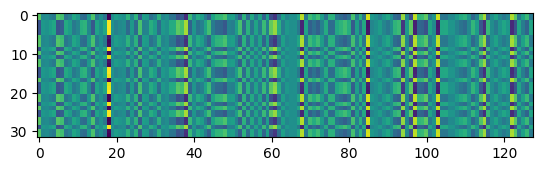

In [26]:
plt.imshow(W_K[0].detach().cpu().numpy().T)

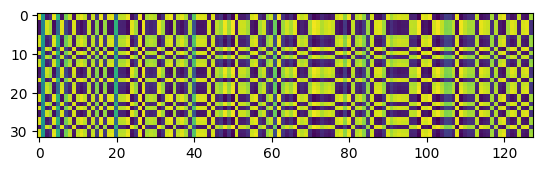

In [27]:
plt.imshow(W_Q[0].detach().cpu().numpy().T)

Ok the key and query matrices are kinda interesting! Maybe they fit together in an interesting way?

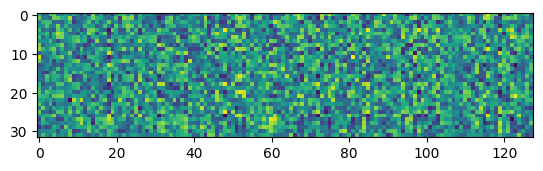

In [28]:
plt.imshow(W_V[0].detach().cpu().numpy().T)

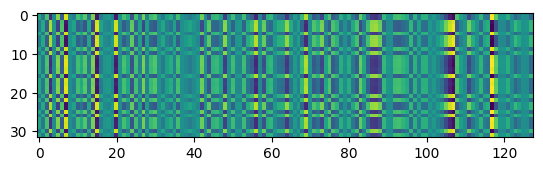

In [29]:
plt.imshow(W_K[1].detach().cpu().numpy().T)

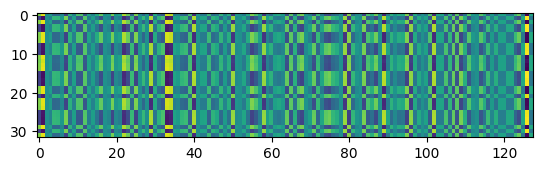

In [30]:
plt.imshow(W_K[2].detach().cpu().numpy().T)

Ok that one looks very Fourier transformy! Could these be cool as a 3d surface? Or too jaged? We'll see. 

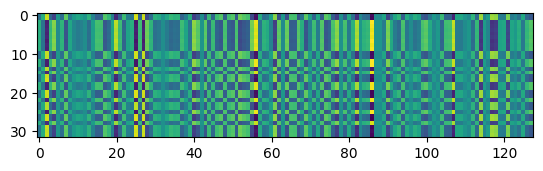

In [31]:
plt.imshow(W_K[3].detach().cpu().numpy().T)

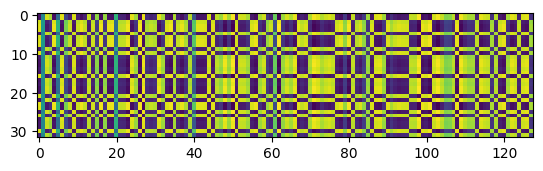

In [32]:
plt.imshow(W_Q[1].detach().cpu().numpy().T)

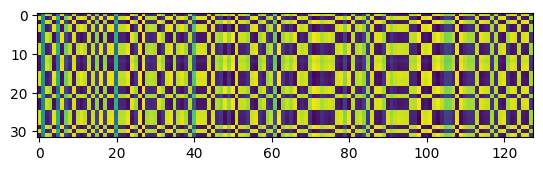

In [33]:
plt.imshow(W_Q[2].detach().cpu().numpy().T)

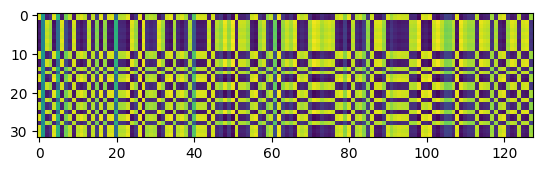

In [34]:
plt.imshow(W_Q[3].detach().cpu().numpy().T)

- Ok cool so I would say like hints of structure in query and key matrix weights - why these!?
- Interesting! 

## Ok now, activations

In [35]:
from ipywidgets import interact

In [40]:
def viz_embeddings(x=0, y=0):
    input_1=t.tensor([[x, y, 113]]).to(device)
    out_1, cache=model.run_with_cache(input_1)    
    plt.plot(cache['hook_embed'][0].detach().cpu().numpy()[:2].T);
    plt.show()

In [39]:
# interact(viz_embeddings) #, x=(0, 1, 113), y=(0, 1, 113))
interact(viz_embeddings, x=(0, 113, 1), y=(0, 113, 1))

interactive(children=(IntSlider(value=0, description='x', max=113), IntSlider(value=0, description='y', max=11…

<function __main__.viz_embeddings(x=0, y=0)>

In [63]:
input_1=t.tensor([[51, 71, 113]]).to(device)
out_1, cache=model.run_with_cache(input_1)
out_1[0, -1, :-1].argmax()

tensor(9, device='cuda:0')

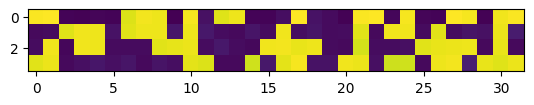

In [64]:
plt.imshow(cache['blocks.0.attn.hook_q'][0, 0].detach().cpu().numpy())

In [68]:
cache['blocks.0.attn.hook_q'].shape

torch.Size([1, 3, 4, 32])

In [69]:
def viz_attn_1(x=0, y=0):
    input_1=t.tensor([[x, y, 113]]).to(device)
    out_1, cache=model.run_with_cache(input_1)    
    fig=plt.figure(0, (6, 4))
    fig.add_subplot(3, 1, 1); plt.imshow(cache['blocks.0.attn.hook_q'][0, 0].detach().cpu().numpy())
    fig.add_subplot(3, 1, 2); plt.imshow(cache['blocks.0.attn.hook_q'][0, 1].detach().cpu().numpy())
    fig.add_subplot(3, 1, 3); plt.imshow(cache['blocks.0.attn.hook_q'][0, 2].detach().cpu().numpy())
    plt.show()

In [70]:
interact(viz_attn_1, x=(0, 113, 1), y=(0, 113, 1))

interactive(children=(IntSlider(value=0, description='x', max=113), IntSlider(value=0, description='y', max=11…

<function __main__.viz_attn_1(x=0, y=0)>

- Ok I don't know what I was expecting, but not this lol!
- It's BINARY, it's all the same pattern, but flips at wierd intervals - dafuq

In [73]:
def viz_attn_2(x=0, y=0):
    input_1=t.tensor([[x, y, 113]]).to(device)
    out_1, cache=model.run_with_cache(input_1)    
    fig=plt.figure(0, (6, 4))
    fig.add_subplot(3, 1, 1); plt.imshow(cache['blocks.0.attn.hook_k'][0, 0].detach().cpu().numpy())
    fig.add_subplot(3, 1, 2); plt.imshow(cache['blocks.0.attn.hook_k'][0, 1].detach().cpu().numpy())
    fig.add_subplot(3, 1, 3); plt.imshow(cache['blocks.0.attn.hook_k'][0, 2].detach().cpu().numpy())
    plt.show()

In [74]:
interact(viz_attn_2, x=(0, 113, 1), y=(0, 113, 1))

interactive(children=(IntSlider(value=0, description='x', max=113), IntSlider(value=0, description='y', max=11…

<function __main__.viz_attn_2(x=0, y=0)>

Keys change more? Ok, interesting.

In [75]:
def viz_attn_3(x=0, y=0):
    input_1=t.tensor([[x, y, 113]]).to(device)
    out_1, cache=model.run_with_cache(input_1)    
    fig=plt.figure(0, (6, 4))
    fig.add_subplot(3, 1, 1); plt.imshow(cache['blocks.0.attn.hook_v'][0, 0].detach().cpu().numpy())
    fig.add_subplot(3, 1, 2); plt.imshow(cache['blocks.0.attn.hook_v'][0, 1].detach().cpu().numpy())
    fig.add_subplot(3, 1, 3); plt.imshow(cache['blocks.0.attn.hook_v'][0, 2].detach().cpu().numpy())
    plt.show()

In [76]:
interact(viz_attn_3, x=(0, 113, 1), y=(0, 113, 1))

interactive(children=(IntSlider(value=0, description='x', max=113), IntSlider(value=0, description='y', max=11…

<function __main__.viz_attn_3(x=0, y=0)>

Ok, so some VERY specific patterns happenign with keys and queries, and kinda more like what I expect - continuous/random for the values. 

In [91]:
def viz_4(x=0, y=0):
    input_1=t.tensor([[x, y, 113]]).to(device)
    out_1, cache=model.run_with_cache(input_1)    
    fig=plt.figure(0, (6, 4))
    fig.add_subplot(4, 1, 1); plt.plot(cache['hook_embed'][0, -1, :-1].detach().cpu().numpy())
    fig.add_subplot(4, 1, 2); plt.plot(cache['blocks.0.hook_attn_out'][0, -1, :-1].detach().cpu().numpy())
    fig.add_subplot(4, 1, 3); plt.plot(cache['blocks.0.hook_mlp_out'][0, -1, :-1].detach().cpu().numpy())
    fig.add_subplot(4, 1, 4); plt.plot(cache['blocks.0.hook_resid_post'][0, -1, :-1].detach().cpu().numpy())
    plt.show()

In [92]:
interact(viz_4, x=(0, 113, 1), y=(0, 113, 1))

interactive(children=(IntSlider(value=0, description='x', max=113), IntSlider(value=0, description='y', max=11…

<function __main__.viz_4(x=0, y=0)>

In [114]:
def viz_5(x=0, y=0):
    input_1=t.tensor([[x, y, 113]]).to(device)
    out_1, cache=model.run_with_cache(input_1)    
    fig=plt.figure(0, (6, 4))
    with t.no_grad():
        manual_unembed=model.unembed(cache['hook_embed'].detach())
        fig.add_subplot(4, 1, 1); plt.plot(manual_unembed[0, -1, :-1].detach().cpu().numpy())
        manual_unembed=model.unembed(cache['blocks.0.hook_attn_out'].detach())
        fig.add_subplot(4, 1, 2); plt.plot(manual_unembed[0, -1, :-1].detach().cpu().numpy())
        manual_unembed=model.unembed(cache['blocks.0.hook_mlp_out'].detach())
        fig.add_subplot(4, 1, 3); plt.plot(manual_unembed[0, -1, :-1].detach().cpu().numpy())
        manual_unembed=model.unembed(cache['blocks.0.hook_resid_post'].detach())
        fig.add_subplot(4, 1, 4); plt.plot(manual_unembed[0, -1, :-1].detach().cpu().numpy())
    plt.show()

In [115]:
interact(viz_5, x=(0, 113, 1), y=(0, 113, 1))

interactive(children=(IntSlider(value=0, description='x', max=113), IntSlider(value=0, description='y', max=11…

<function __main__.viz_5(x=0, y=0)>

Ok, that's cool.

In [113]:
for k in cache.keys():
    print(k, cache[k].shape)

hook_embed torch.Size([1, 3, 128])
hook_pos_embed torch.Size([1, 3, 128])
blocks.0.hook_resid_pre torch.Size([1, 3, 128])
blocks.0.attn.hook_q torch.Size([1, 3, 4, 32])
blocks.0.attn.hook_k torch.Size([1, 3, 4, 32])
blocks.0.attn.hook_v torch.Size([1, 3, 4, 32])
blocks.0.attn.hook_attn_scores torch.Size([1, 4, 3, 3])
blocks.0.attn.hook_pattern torch.Size([1, 4, 3, 3])
blocks.0.attn.hook_z torch.Size([1, 3, 4, 32])
blocks.0.hook_attn_out torch.Size([1, 3, 128])
blocks.0.hook_resid_mid torch.Size([1, 3, 128])
blocks.0.mlp.hook_pre torch.Size([1, 3, 512])
blocks.0.mlp.hook_post torch.Size([1, 3, 512])
blocks.0.hook_mlp_out torch.Size([1, 3, 128])
blocks.0.hook_resid_post torch.Size([1, 3, 128])


In [116]:
def viz_6(x=0, y=0):
    input_1=t.tensor([[x, y, 113]]).to(device)
    out_1, cache=model.run_with_cache(input_1)    
    fig=plt.figure(0, (6, 4))
    fig.add_subplot(4, 1, 1); plt.plot(cache['blocks.0.mlp.hook_pre'][0, -1, :-1].detach().cpu().numpy())
    fig.add_subplot(4, 1, 2); plt.plot(cache['blocks.0.mlp.hook_post'][0, -1, :-1].detach().cpu().numpy())
    # fig.add_subplot(4, 1, 3); plt.plot(cache['blocks.0.hook_mlp_out'][0, -1, :-1].detach().cpu().numpy())
    # fig.add_subplot(4, 1, 4); plt.plot(cache['blocks.0.hook_resid_post'][0, -1, :-1].detach().cpu().numpy())
    plt.show()

In [117]:
interact(viz_6, x=(0, 113, 1), y=(0, 113, 1))

interactive(children=(IntSlider(value=0, description='x', max=113), IntSlider(value=0, description='y', max=11…

<function __main__.viz_6(x=0, y=0)>

In [98]:
x=60; y=60
input_1=t.tensor([[x, y, 113]]).to(device)
out_1, cache=model.run_with_cache(input_1)

In [99]:
out_1.shape

torch.Size([1, 3, 114])

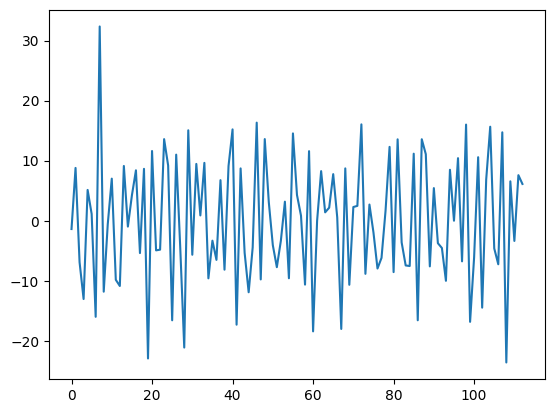

In [100]:
plt.plot(out_1[0, -1, :-1].detach().cpu().numpy())

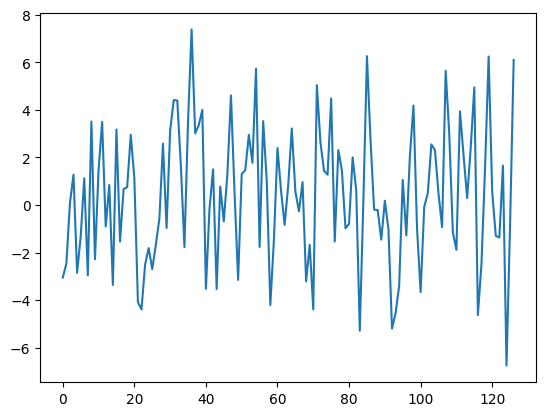

In [102]:
plt.plot(cache['blocks.0.hook_resid_post'][0, -1, :-1].detach().cpu().numpy())

- WTF is happening between blocks.0.hook_resid_post and the final output??
- Oh I guess the unembed?

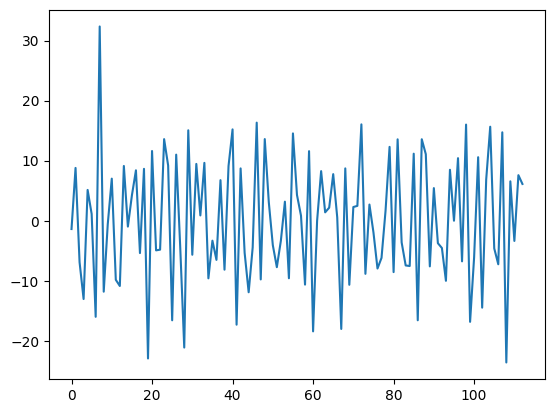

In [107]:
with t.no_grad():
    manual_unembed=model.unembed(cache['blocks.0.hook_resid_post'].detach())
plt.plot(manual_unembed[0, -1, :-1].detach().cpu().numpy())

In [80]:
for k in cache.keys():
    print(k, cache[k].shape)

hook_embed torch.Size([1, 3, 128])
hook_pos_embed torch.Size([1, 3, 128])
blocks.0.hook_resid_pre torch.Size([1, 3, 128])
blocks.0.attn.hook_q torch.Size([1, 3, 4, 32])
blocks.0.attn.hook_k torch.Size([1, 3, 4, 32])
blocks.0.attn.hook_v torch.Size([1, 3, 4, 32])
blocks.0.attn.hook_attn_scores torch.Size([1, 4, 3, 3])
blocks.0.attn.hook_pattern torch.Size([1, 4, 3, 3])
blocks.0.attn.hook_z torch.Size([1, 3, 4, 32])
blocks.0.hook_attn_out torch.Size([1, 3, 128])
blocks.0.hook_resid_mid torch.Size([1, 3, 128])
blocks.0.mlp.hook_pre torch.Size([1, 3, 512])
blocks.0.mlp.hook_post torch.Size([1, 3, 512])
blocks.0.hook_mlp_out torch.Size([1, 3, 128])
blocks.0.hook_resid_post torch.Size([1, 3, 128])


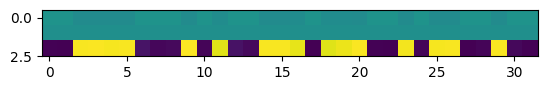

In [51]:
plt.imshow(cache['blocks.0.attn.hook_q'][0, :,0].detach().cpu().numpy())

In [55]:
cache['blocks.0.attn.hook_q'][0, :,0]

tensor([[ 0.0545,  0.0553, -0.0547, -0.0549, -0.0542, -0.0546,  0.0496,  0.0535,
          0.0525, -0.0556,  0.0539, -0.0506,  0.0500,  0.0527, -0.0544, -0.0543,
         -0.0517,  0.0552, -0.0501, -0.0524, -0.0548,  0.0545,  0.0550, -0.0536,
          0.0539, -0.0543, -0.0544,  0.0553,  0.0536, -0.0548,  0.0528,  0.0548],
        [-0.0025, -0.0025,  0.0025,  0.0025,  0.0025,  0.0025, -0.0023, -0.0025,
         -0.0024,  0.0025, -0.0025,  0.0023, -0.0023, -0.0024,  0.0025,  0.0025,
          0.0024, -0.0025,  0.0023,  0.0024,  0.0025, -0.0025, -0.0025,  0.0025,
         -0.0025,  0.0025,  0.0025, -0.0025, -0.0025,  0.0025, -0.0024, -0.0025],
        [-1.8527, -1.8779,  1.8586,  1.8644,  1.8428,  1.8539, -1.6854, -1.8179,
         -1.7826,  1.8892, -1.8327,  1.7183, -1.6983, -1.7895,  1.8468,  1.8463,
          1.7555, -1.8761,  1.7020,  1.7796,  1.8616, -1.8518, -1.8698,  1.8218,
         -1.8301,  1.8439,  1.8497, -1.8784, -1.8213,  1.8617, -1.7950, -1.8610]],
       device='cuda:0')

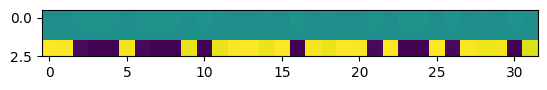

In [52]:
plt.imshow(cache['blocks.0.attn.hook_q'][0, :,1].detach().cpu().numpy())

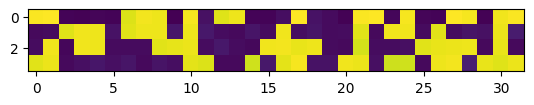

In [45]:
plt.imshow(cache['blocks.0.attn.hook_q'][0, 0].detach().cpu().numpy())

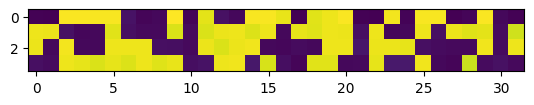

In [47]:
plt.imshow(cache['blocks.0.attn.hook_q'][0, 1].detach().cpu().numpy())

Hmm close to binary and inverses, interesting. 

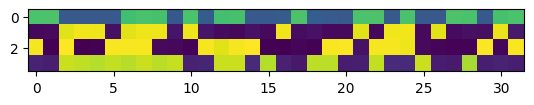

In [49]:
plt.imshow(cache['blocks.0.attn.hook_k'][0, 0].detach().cpu().numpy())

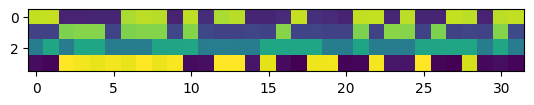

In [50]:
plt.imshow(cache['blocks.0.attn.hook_k'][0, 1].detach().cpu().numpy())

In [46]:
cache['blocks.0.attn.hook_q'][0, 0] #Hmm why are these values so consistent? 

tensor([[ 0.0545,  0.0553, -0.0547, -0.0549, -0.0542, -0.0546,  0.0496,  0.0535,
          0.0525, -0.0556,  0.0539, -0.0506,  0.0500,  0.0527, -0.0544, -0.0543,
         -0.0517,  0.0552, -0.0501, -0.0524, -0.0548,  0.0545,  0.0550, -0.0536,
          0.0539, -0.0543, -0.0544,  0.0553,  0.0536, -0.0548,  0.0528,  0.0548],
        [-0.0526, -0.0522,  0.0500,  0.0529,  0.0526, -0.0501,  0.0505,  0.0524,
          0.0524, -0.0488,  0.0523, -0.0486, -0.0519, -0.0526, -0.0494, -0.0523,
          0.0527, -0.0513, -0.0495, -0.0524, -0.0521,  0.0502, -0.0526,  0.0531,
          0.0528, -0.0524,  0.0502, -0.0519, -0.0499, -0.0505,  0.0520, -0.0470],
        [-0.0519,  0.0528, -0.0535,  0.0528,  0.0525, -0.0524, -0.0525, -0.0523,
          0.0504,  0.0510,  0.0522, -0.0519, -0.0487, -0.0521, -0.0531,  0.0527,
          0.0533,  0.0517,  0.0525, -0.0524, -0.0527,  0.0481, -0.0521, -0.0521,
         -0.0509,  0.0504,  0.0515,  0.0522,  0.0523, -0.0529,  0.0517, -0.0526],
        [ 0.0502,  0.0519

## Now Maybe explore activations across ranges of inputs?

In [ ]:
all_data = t.tensor([(i, j, p) for i in range(p) for j in range(p)]).to(device)
labels = t.tensor([utils.target_fn(i, j) for i, j, _ in all_data]).to(device)
original_logits, cache = model.run_with_cache(all_data)

In [169]:
# final_pos_resid_initial

## Now explore functional form

In [118]:
#After I poke around full model will be cool to poke around this functional form!

W_logit = W_out @ W_U #MLP out here 

W_OV = W_V @ W_O #Attn out here
W_neur = W_E @ W_OV @ W_in

W_QK = W_Q @ W_K.transpose(-1, -2)
W_attn = final_pos_resid_initial @ W_QK @ W_E.T / (cfg.d_head**0.5) #This involves some data? That's intersting. 

# Test shapes
assert W_logit.shape == (cfg.d_mlp, cfg.d_vocab - 1)
assert W_neur.shape == (cfg.n_heads, cfg.d_vocab - 1, cfg.d_mlp)
assert W_attn.shape == (cfg.n_heads, cfg.d_vocab - 1)

# Test values
tests.test_effective_weights(W_logit, W_neur, W_attn, model)

All tests from `test_effective_weights` passed!


In [119]:
W_logit.shape

torch.Size([512, 113])

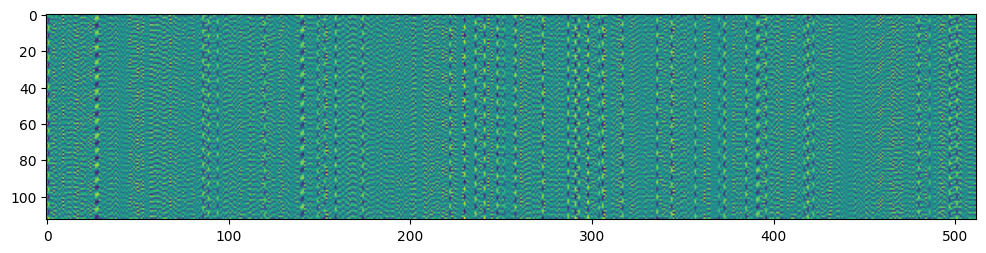

In [124]:
plt.figure(0, (12, 6))
plt.imshow(W_logit.detach().cpu().numpy().T)

Hmm that seems like some interseting structure. 

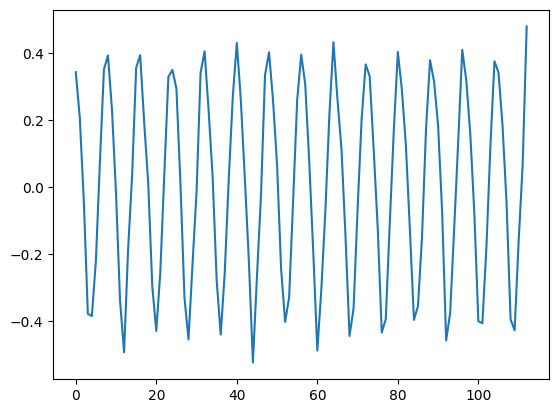

In [127]:
plt.plot(W_logit[1, :].detach().cpu().numpy()) #Oh wow yeah very periodic. 

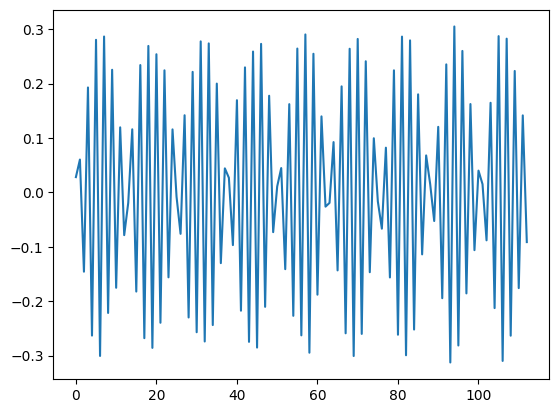

In [138]:
plt.plot(W_logit[23, :].detach().cpu().numpy()) #Oh wow yeah very periodic. 

Oh wow that one is nice!

In [139]:
W_OV.shape

torch.Size([4, 128, 128])

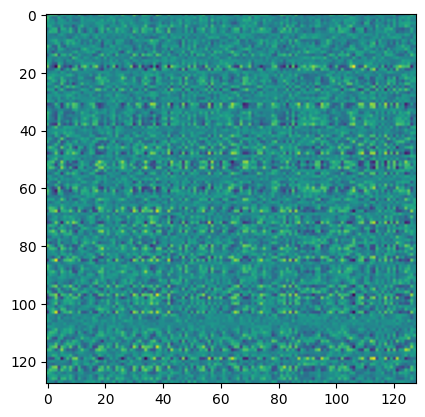

In [146]:
plt.imshow(W_OV[0].detach().cpu().numpy()) #Some structure here for sure, but nothing like mind-blowing. 

In [147]:
W_neur.shape

torch.Size([4, 113, 512])

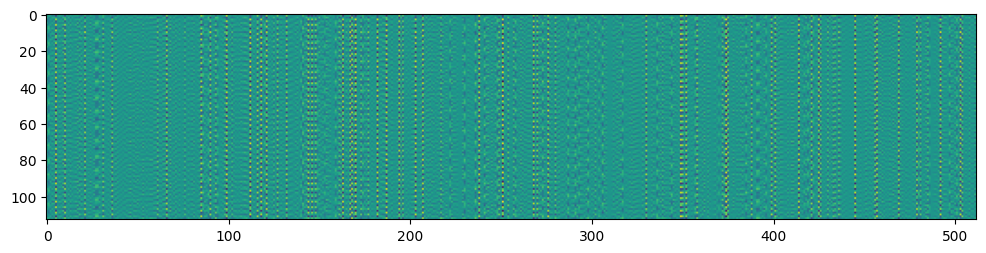

In [149]:
plt.figure(0, (12, 6))
plt.imshow(W_neur[0].detach().cpu().numpy())

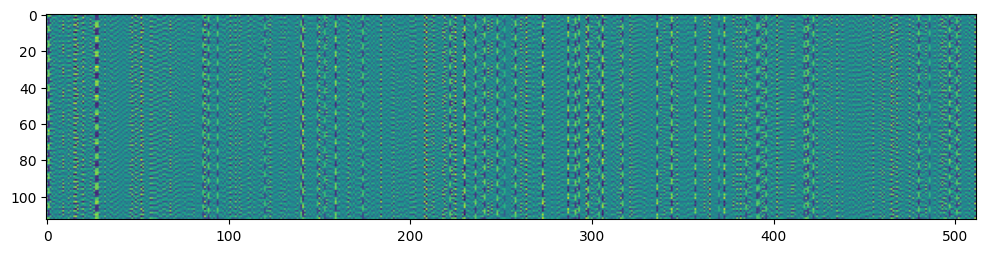

In [150]:
plt.figure(0, (12, 6))
plt.imshow(W_neur[1].detach().cpu().numpy())

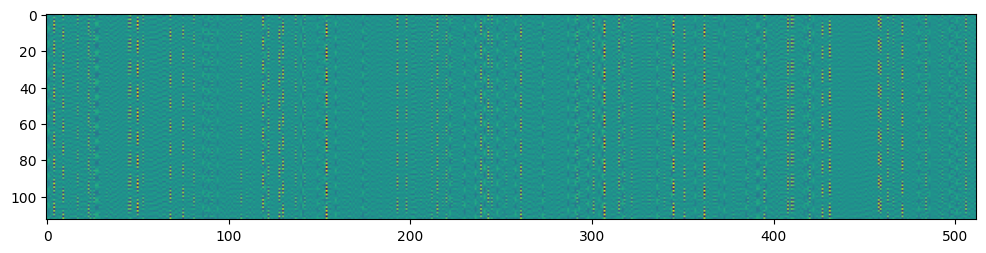

In [153]:
plt.figure(0, (12, 6))
plt.imshow(W_neur[2].detach().cpu().numpy())

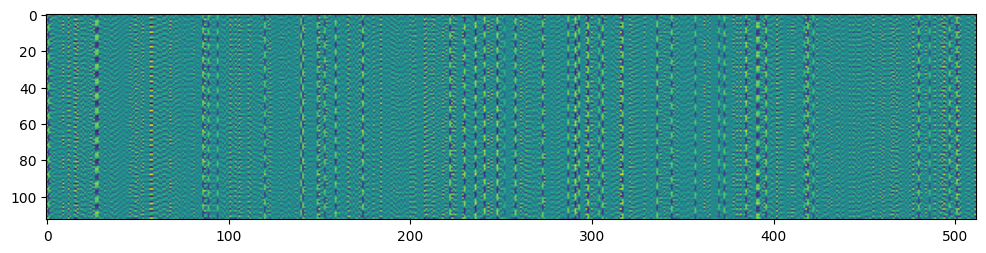

In [154]:
plt.figure(0, (12, 6))
plt.imshow(W_neur[3].detach().cpu().numpy())

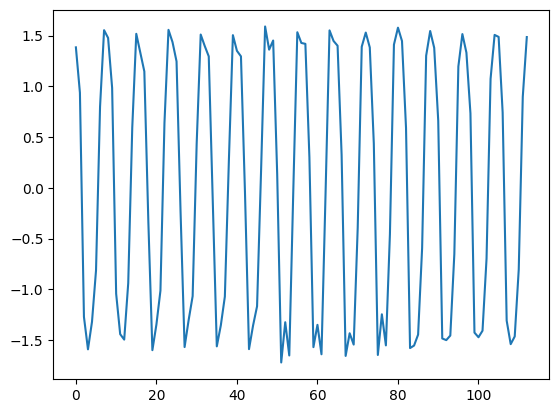

In [167]:
plt.plot(W_neur[3, :, 1].detach().cpu().numpy()) #Oh wow yeah very periodic. 

Ok wow yeah nice

- Ok yeah so functional form is defintely more Fourier-y.
- Interesting interesting.

---

In [15]:
all_data

tensor([[  0,   0, 113],
        [  0,   1, 113],
        [  0,   2, 113],
        ...,
        [112, 110, 113],
        [112, 111, 113],
        [112, 112, 113]], device='cuda:0')

In [16]:
all_data.shape

torch.Size([12769, 3])

In [17]:
labels.shape

torch.Size([12769])

In [18]:
# model

In [19]:
out,cache=model.run_with_cache(all_data)

In [22]:
i=3
out[i, -1, :-1].argmax()

tensor(3, device='cuda:0')

In [41]:
p

113

In [39]:
(100+100)%113

87

In [24]:
input_1

tensor([[ 10,  10, 113]], device='cuda:0')

In [25]:

# out_1,cache=model.run_with_cache(input_1)
out_1.shape

torch.Size([1, 3, 114])

In [26]:
out_1[0, -1, :-1].argmax()

tensor(20, device='cuda:0')

In [27]:
t.nn.Softmax(0)(out_1[0, -1, :-1])

tensor([7.7399e-19, 1.4824e-11, 5.2967e-23, 4.4059e-13, 1.4098e-08, 3.9608e-17,
        6.0292e-18, 2.4313e-09, 1.1064e-27, 1.8200e-12, 5.4826e-18, 6.5991e-13,
        1.3054e-11, 2.0451e-15, 9.2715e-12, 1.6305e-18, 4.7896e-21, 3.4686e-14,
        6.2491e-16, 6.0330e-23, 1.0000e+00, 3.4173e-21, 4.3110e-15, 3.2396e-12,
        8.2233e-21, 3.3887e-21, 4.4439e-12, 4.5049e-17, 5.7521e-13, 2.1471e-11,
        5.3709e-18, 1.0440e-11, 1.0678e-25, 1.3654e-10, 8.8402e-19, 4.6853e-18,
        3.6331e-09, 1.8125e-11, 1.6953e-22, 2.7830e-10, 5.2253e-19, 2.8687e-25,
        1.4424e-08, 8.8234e-20, 3.1388e-10, 2.7431e-14, 7.3471e-12, 8.5462e-20,
        8.6580e-17, 2.3364e-19, 4.1378e-13, 8.9881e-20, 2.6452e-11, 3.8136e-08,
        8.4197e-23, 8.1420e-11, 9.2585e-19, 8.8390e-21, 3.0114e-18, 2.4965e-09,
        1.8955e-19, 1.3986e-08, 5.9094e-14, 1.5319e-17, 1.3467e-18, 1.0911e-17,
        2.3316e-15, 1.8502e-20, 9.6832e-09, 2.5099e-14, 1.6267e-14, 1.3987e-19,
        2.6864e-11, 1.7670e-24, 6.1619e-

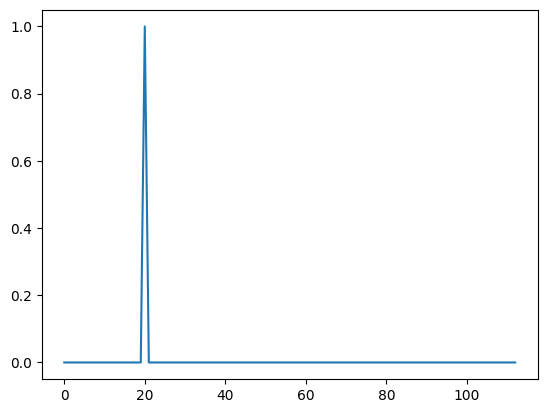

In [28]:
plt.plot(t.nn.Softmax(0)(out_1[0, -1, :-1]).detach().cpu().numpy())

In [10]:
#After I poke around full model will be cool to poke around this functional form!

W_logit = W_out @ W_U

W_OV = W_V @ W_O
W_neur = W_E @ W_OV @ W_in

W_QK = W_Q @ W_K.transpose(-1, -2)
W_attn = final_pos_resid_initial @ W_QK @ W_E.T / (cfg.d_head**0.5)

# Test shapes
assert W_logit.shape == (cfg.d_mlp, cfg.d_vocab - 1)
assert W_neur.shape == (cfg.n_heads, cfg.d_vocab - 1, cfg.d_mlp)
assert W_attn.shape == (cfg.n_heads, cfg.d_vocab - 1)

# Test values
tests.test_effective_weights(W_logit, W_neur, W_attn, model)

All tests from `test_effective_weights` passed!
